# Towards a Rigorous Evaluation of XAI Methods on Time Series

## 📥 1. Import Required Libraries

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## 📥 2. Load and Preprocess FordA dataset

In [5]:
def load_forda_data():
    train = np.loadtxt("FordA/FordA_TRAIN.txt")
    test = np.loadtxt("FordA/FordA_TEST.txt")
    
    y_train, X_train = train[:, 0], train[:, 1:]
    y_test, X_test = test[:, 0], test[:, 1:]
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_forda_data()


## 2. Create DataLoaders

In [7]:
def create_dataloader(X, y, batch_size=32):
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # add channel dim
    y_tensor = torch.tensor((y > 0).astype(np.int64))  # convert -1/1 to 0/1
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_dataloader(X_train, y_train)
test_loader = create_dataloader(X_test, y_test)


## 4. Define Model Architectures

### Simple CNN

In [95]:
class SimpleCNN(nn.Module):
    def __init__(self, num_channels=1, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.global_pool(x).squeeze(-1)
        return self.fc(x)

### ResNet 1D

In [101]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.0317):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.skip = nn.Sequential()
        if in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        return self.relu(out)

class ResNet1D(nn.Module):
    def __init__(self, num_channels=1, num_classes=2):
        super(ResNet1D, self).__init__()
        self.layer1 = ResBlock(num_channels, 128)
        self.layer2 = ResBlock(128, 32)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

## 5. Training Loop

In [107]:
def train_model(model, train_loader, test_loader, epochs=15, lr=0.0147, weight_decay=1.847e-5, clip_grad=2.645, patience=7):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.989, 0.999), weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    best_acc = 0
    patience_counter = 0
    model.to(device)

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
        scheduler.step()

        # Eval on test set
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                preds = model(X_batch).argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(y_batch.numpy())
        acc = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}/{epochs}, Test Accuracy: {acc:.4f}")

        # Early stopping
        if acc > best_acc:
            best_acc = acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break


## 6. Device & Model Initialization

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cnn = SimpleCNN()
model_resnet = ResNet1D()


## 7. Train Models

In [112]:
print("\nTraining CNN:")
cnn_model = SimpleCNN()
train_model(cnn_model, train_loader, test_loader, epochs=15)  # use same epochs for fairness

print("\nTraining ResNet1D with Best Hyperparameters:")
resnet_model = ResNet1D()
train_model(resnet_model, train_loader, test_loader,
            epochs=15,
            lr=0.014733891162594277,
            weight_decay=1.8470553092879813e-05,
            clip_grad=2.645571725495685,
            patience=7)


Training CNN:
Epoch 1/15, Test Accuracy: 0.8242
Epoch 2/15, Test Accuracy: 0.8833
Epoch 3/15, Test Accuracy: 0.8780
Epoch 4/15, Test Accuracy: 0.8992
Epoch 5/15, Test Accuracy: 0.9000
Epoch 6/15, Test Accuracy: 0.8947
Epoch 7/15, Test Accuracy: 0.9045
Epoch 8/15, Test Accuracy: 0.9008
Epoch 9/15, Test Accuracy: 0.8985
Epoch 10/15, Test Accuracy: 0.9030
Epoch 11/15, Test Accuracy: 0.9076
Epoch 12/15, Test Accuracy: 0.9076
Epoch 13/15, Test Accuracy: 0.9008
Epoch 14/15, Test Accuracy: 0.9000
Epoch 15/15, Test Accuracy: 0.8902

Training ResNet1D with Best Hyperparameters:
Epoch 1/15, Test Accuracy: 0.5159
Epoch 2/15, Test Accuracy: 0.5758
Epoch 3/15, Test Accuracy: 0.7068
Epoch 4/15, Test Accuracy: 0.5553
Epoch 5/15, Test Accuracy: 0.8182
Epoch 6/15, Test Accuracy: 0.7795
Epoch 7/15, Test Accuracy: 0.8212
Epoch 8/15, Test Accuracy: 0.8083
Epoch 9/15, Test Accuracy: 0.8265
Epoch 10/15, Test Accuracy: 0.6644
Epoch 11/15, Test Accuracy: 0.8053
Epoch 12/15, Test Accuracy: 0.8152
Epoch 13/15,

## 🔍 8. Explainability with Captum

We use three gradient-based XAI methods from the Captum library:
- **Saliency Maps**
- **Integrated Gradients**
- **DeepLIFT**

The function `explain_sample` computes the attribution maps for a given model and input sample using the above techniques.


In [116]:
import matplotlib.pyplot as plt
from captum.attr import Saliency, IntegratedGradients, DeepLift
import numpy as np

def explain_sample(model, input_tensor, target_class):
    model.eval()
    input_tensor.requires_grad = True
    
    saliency = Saliency(model)
    ig = IntegratedGradients(model)
    dl = DeepLift(model)
    
    attr_saliency = saliency.attribute(input_tensor, target=target_class)
    attr_ig = ig.attribute(input_tensor, target=target_class, n_steps=50)
    attr_dl = dl.attribute(input_tensor, target=target_class)
    
    return attr_saliency, attr_ig, attr_dl


## 9. Heatmap Visualization

To better understand the importance of different time steps in the model's decision, we use a heatmap overlay.

The function `plot_heatmap` visualizes the attribution scores on top of the original time series signal.


In [119]:
def plot_heatmap(attr, original_signal, title="Attribution Heatmap"):
    attr = attr.squeeze().cpu().detach().numpy()
    ts = original_signal.squeeze().cpu().detach().numpy()

    plt.figure(figsize=(12, 4))
    plt.plot(ts, label="Original Time Series", alpha=0.8)
    plt.imshow(attr[np.newaxis, :], cmap="viridis", aspect="auto", 
               extent=[0, len(ts), np.min(ts), np.max(ts)], alpha=0.6)
    plt.title(title)
    plt.colorbar(label="Attribution Score")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [121]:
sample_batch, label_batch = next(iter(test_loader))
sample = sample_batch[0:1].to(device)
label = label_batch[0].item()

print(f"Sample label: {label}")


Sample label: 0


## 10. Explanations from CNN

We apply different XAI methods — **Saliency Maps**, **Integrated Gradients**, and **DeepLift** — to a sample input using the trained `SimpleCNN` model.

The heatmaps below show how each method attributes importance to different parts of the time series.


/opt/anaconda3/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


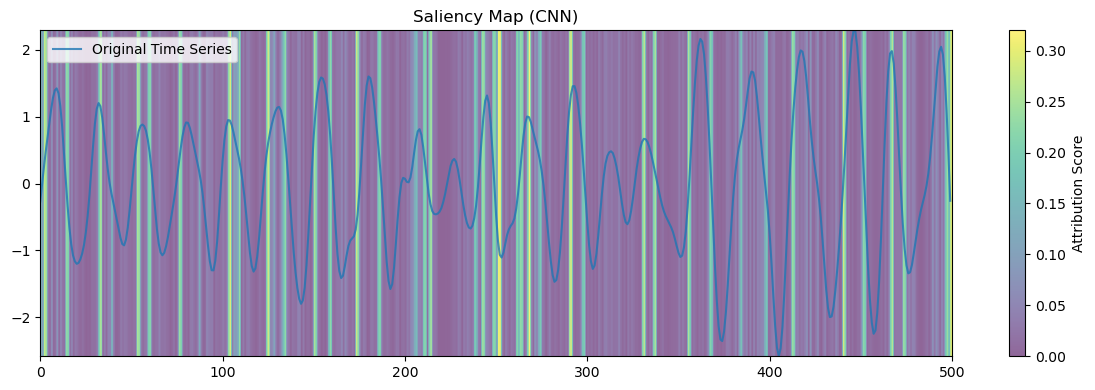

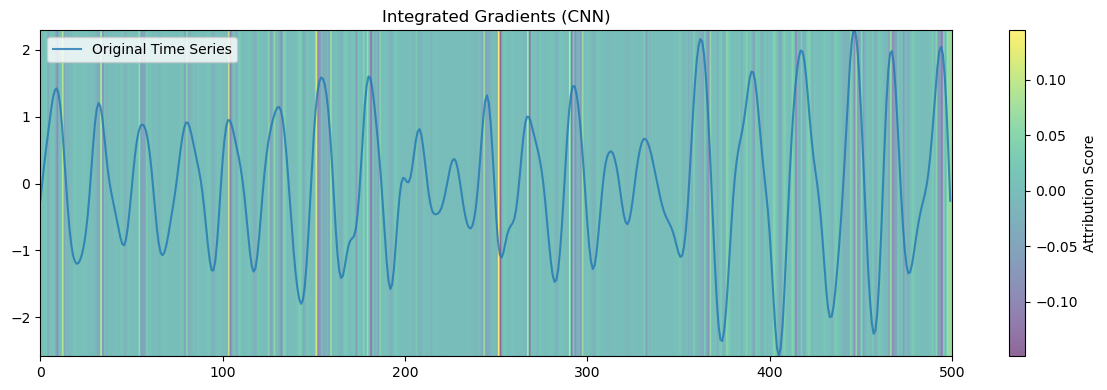

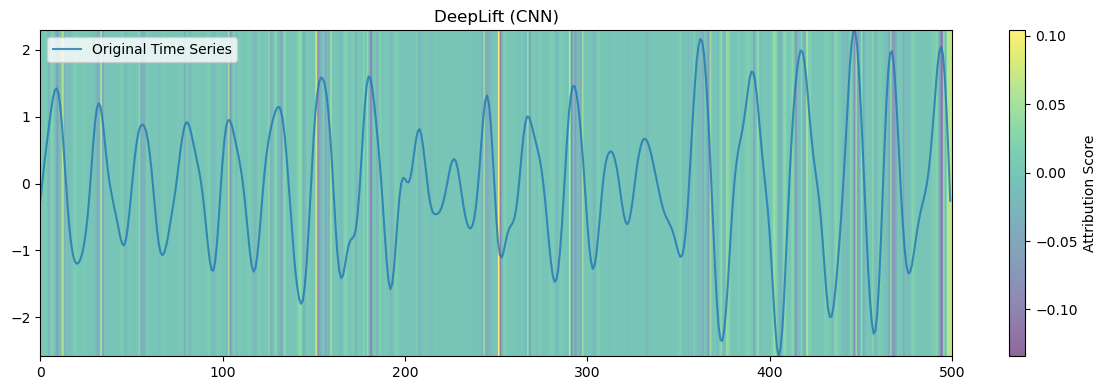

In [124]:
# Explanations from CNN
attr_saliency, attr_ig, attr_dl = explain_sample(model_cnn, sample.clone(), label)

# Plot
plot_heatmap(attr_saliency, sample, title="Saliency Map (CNN)")
plot_heatmap(attr_ig, sample, title="Integrated Gradients (CNN)")
plot_heatmap(attr_dl, sample, title="DeepLift (CNN)")


## 11. Explanations from ResNet1D

We now apply the same XAI methods — **Saliency Maps**, **Integrated Gradients**, and **DeepLift** — to the `ResNet1D` model.

The visualizations below reveal how the attributions differ between models and highlight which parts of the input signal influenced the model’s predictions.


/opt/anaconda3/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


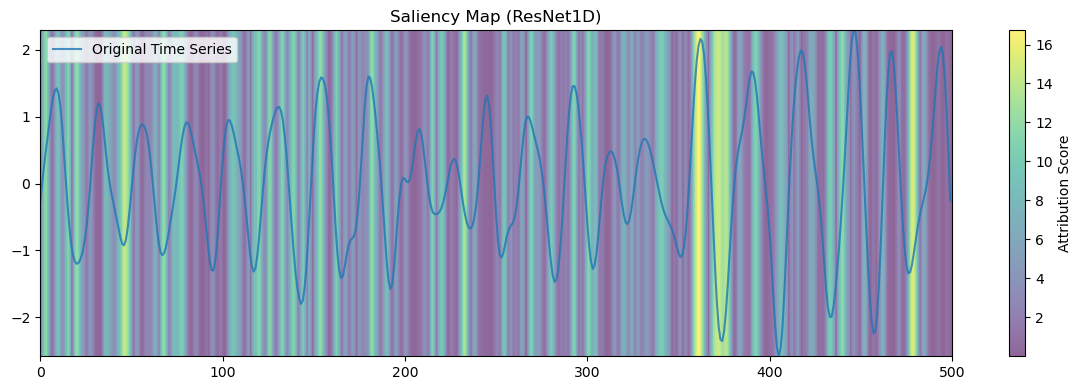

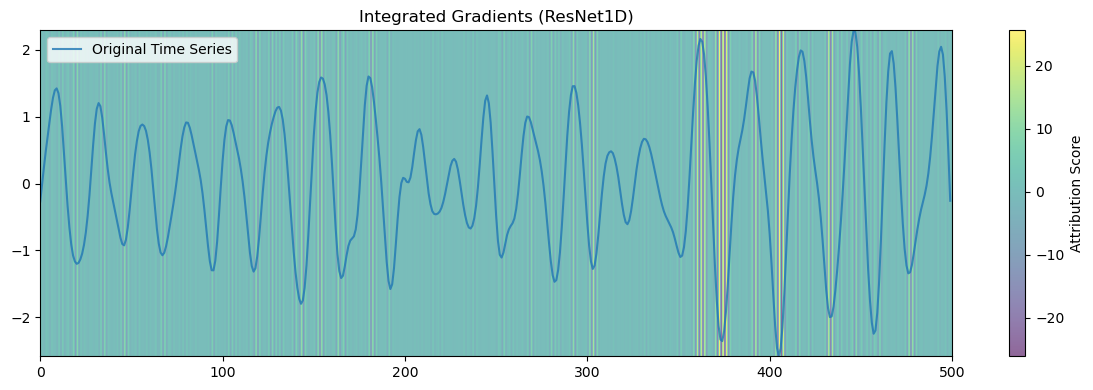

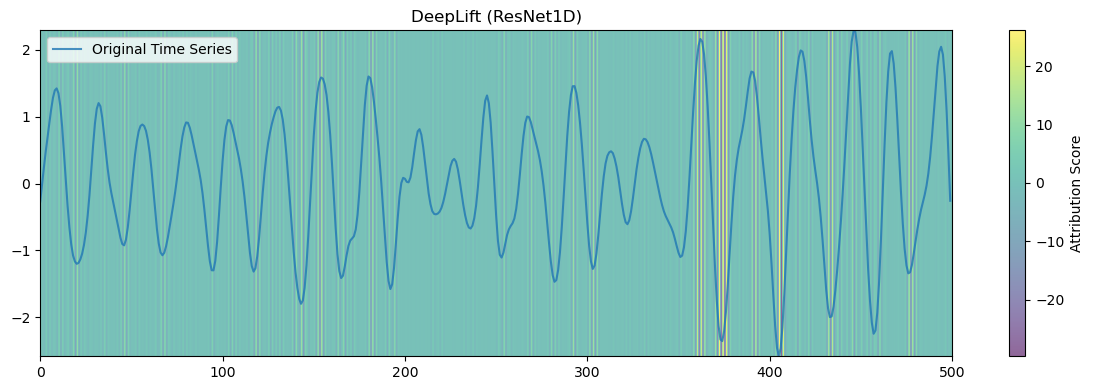

In [127]:
# Explanations from ResNet
attr_saliency_r, attr_ig_r, attr_dl_r = explain_sample(model_resnet, sample.clone(), label)

# Plot
plot_heatmap(attr_saliency_r, sample, title="Saliency Map (ResNet1D)")
plot_heatmap(attr_ig_r, sample, title="Integrated Gradients (ResNet1D)")
plot_heatmap(attr_dl_r, sample, title="DeepLift (ResNet1D)")


## 12. Quantitative Metrics: Infidelity and Sensitivity

To rigorously evaluate each explanation method, we compute two widely-used metrics from Captum:

- **Infidelity**: Measures how much the attributions change when the input is perturbed.
- **Sensitivity**: Evaluates how sensitive the attributions are to small changes in input.

These metrics help assess the *faithfulness* and *robustness* of different explanation methods.


In [130]:
from captum.metrics import infidelity, sensitivity_max

def compute_infidelity(model, input_tensor, target, attributions):
    def perturb_fn(inputs):
        # Generate noise and return (noise, perturbed inputs)
        noise = torch.randn_like(inputs) * 0.1
        return noise, inputs - noise

    # Note: We pass precomputed `attributions` (e.g., attr_ig) to infidelity.
    return infidelity(
        model,           # forward function (your model)
        perturb_fn,      # perturbation function
        input_tensor,    # the input tensor
        attributions,    # precomputed attributions
        target=target    # target class
    ).item()

def compute_sensitivity(attribution_fn, input_tensor, target):
    # sensitivity_max expects an attribution function, so we can pass ig.attribute directly.
    return sensitivity_max(attribution_fn, input_tensor, target=target).item()


## 13. Deletion & Insertion Curves

To visually assess the importance of attributed features, we use **Deletion** and **Insertion** metrics:

- **Deletion**: Gradually remove the most important features and observe how model confidence drops.
- **Insertion**: Start from a baseline (e.g., zeros), then gradually add the most important features and observe how model confidence increases.

These plots help determine whether the explanation method truly identifies features critical for the model’s prediction.


In [133]:
def deletion_insertion_curve(model, input_tensor, attributions, target, mode="deletion", steps=50):
    input_tensor = input_tensor.clone().detach().cpu().squeeze().numpy()
    attributions = attributions.squeeze().cpu().detach().numpy()

    sorted_idx = np.argsort(attributions)[::-1]  # Most important first
    baseline = np.zeros_like(input_tensor)

    scores = []
    modified = input_tensor.copy()
    for i in range(1, steps+1):
        k = int((i / steps) * len(sorted_idx))
        if mode == "deletion":
            modified = input_tensor.copy()
            modified[sorted_idx[:k]] = 0
        elif mode == "insertion":
            modified = baseline.copy()
            modified[sorted_idx[:k]] = input_tensor[sorted_idx[:k]]

        input_mod = torch.tensor(modified, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        prob = torch.softmax(model(input_mod), dim=1)[0, target].item()
        scores.append(prob)

    return scores


## 📊 14. Plotting Deletion vs Insertion Curves

We now visualize the deletion and insertion scores computed earlier. This helps assess how much the model depends on top-ranked features:

- A **steep drop** in the deletion curve indicates reliance on those features.
- A **steep rise** in the insertion curve suggests high relevance of the added features.

We generate both curves on the same plot for side-by-side comparison of interpretability effectiveness.


In [136]:
def plot_deletion_insertion(model, input_tensor, attribution, target, title_prefix=""):
    del_scores = deletion_insertion_curve(model, input_tensor, attribution, target, mode="deletion")
    ins_scores = deletion_insertion_curve(model, input_tensor, attribution, target, mode="insertion")

    x = np.linspace(0, 1, len(del_scores))
    plt.figure(figsize=(10, 5))
    plt.plot(x, del_scores, label="Deletion", color='red')
    plt.plot(x, ins_scores, label="Insertion", color='green')
    plt.title(f"{title_prefix} - Deletion vs Insertion Curve")
    plt.xlabel("Fraction of Perturbed Input")
    plt.ylabel("Prediction Probability")
    plt.legend()
    plt.grid(True)
    plt.show()


In [138]:
sample_batch, label_batch = next(iter(test_loader))
sample = sample_batch[0:1].to(device)  # e.g., shape (1, 1, time_length)
label = label_batch[0].item()

ig = IntegratedGradients(model_cnn)
attr_ig = ig.attribute(sample, target=label, n_steps=50)


## 📈 15. Quantitative Evaluation of Explanations (Captum)

We now perform a **rigorous quantitative comparison** of the XAI methods (`Saliency`, `Integrated Gradients`, and `DeepLift`) across both models using the following metrics:

- 🔻 **Infidelity**: Measures how well the attributions match the model’s behavior under input perturbations.
- 🌪 **Sensitivity Max**: Measures attribution consistency under small input perturbations.
- 🟥 **Deletion AUC**: A lower AUC indicates the model relies on the most attributed features.
- 🟩 **Insertion AUC**: A higher AUC shows rapid confidence gain as informative features are added.

Each metric is plotted as a heatmap across methods and models for easy visual comparison.


/opt/anaconda3/lib/python3.12/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/opt/anaconda3/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/opt/anaconda3/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


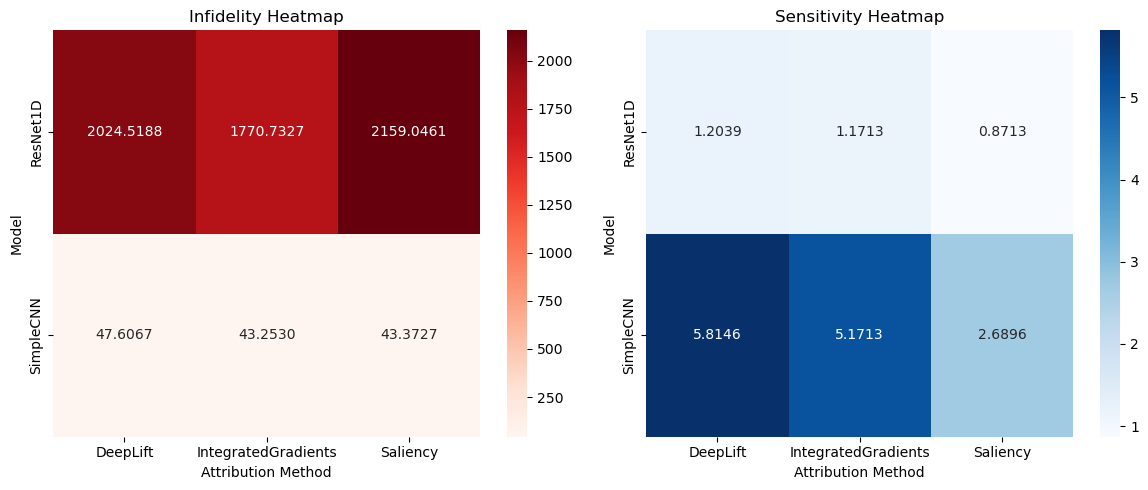

In [141]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from captum.attr import IntegratedGradients, Saliency, DeepLift
from captum.metrics import infidelity, sensitivity_max

def compute_all_metrics(model, sample, label):
    """
    For a given model and a sample, compute Infidelity and Sensitivity metrics 
    for each attribution method.
    """
    methods = {
        "IntegratedGradients": IntegratedGradients(model),
        "Saliency": Saliency(model),
        "DeepLift": DeepLift(model)
    }
    
    # Convert the label to a tensor if it's not already
    if isinstance(label, int):
        label_tensor = label
    else:
        label_tensor = label
    
    results = {}
    for name, attr_obj in methods.items():
        # Compute attributions; use n_steps for IntegratedGradients
        if name == "IntegratedGradients":
            attr_map = attr_obj.attribute(sample, target=label_tensor, n_steps=50)
        else:
            attr_map = attr_obj.attribute(sample, target=label_tensor)
            
        # Define a perturbation function for Infidelity:
        def perturb_fn(inputs):
            noise = torch.randn_like(inputs) * 0.1
            return noise, inputs - noise
        
        # Compute Infidelity with correct argument order:
        infid_value = infidelity(
            model,         # forward function
            perturb_fn,    # perturbation function
            sample,        # input tensor
            attr_map,      # precomputed attributions
            target=label_tensor   # target label
        ).item()
        
        # Fix for sensitivity_max - create a properly scoped function that will correctly handle the target
        def create_attr_func(attribution_object, target):
            def attr_func(inputs):
                return attribution_object.attribute(inputs, target=target)
            return attr_func
        
        # Use the properly scoped attribution function
        attr_func = create_attr_func(attr_obj, label_tensor)
        
        # Compute Sensitivity with the fixed attribution function
        sens_value = sensitivity_max(
            attr_func,  # Use the new attribution function
            sample,
            n_perturb_samples=10,  # Use a reasonable number of perturbation samples
            perturb_radius=0.1     # Set a reasonable perturbation radius
        ).item()
        
        results[name] = {
            "Infidelity": infid_value,
            "Sensitivity": sens_value
        }
    
    return results

# Get one sample from the test loader for evaluation
sample_batch, label_batch = next(iter(test_loader))
sample = sample_batch[0:1].to(device)  # shape: (1, 1, time_length)
label = label_batch[0].item()

# Compute metrics for both models
results_cnn = compute_all_metrics(model_cnn, sample, label)
results_resnet = compute_all_metrics(model_resnet, sample, label)

# Combine results into a nested dictionary
all_results = {
    "SimpleCNN": results_cnn,
    "ResNet1D": results_resnet
}

# Convert nested dictionary into a DataFrame for heatmap plotting
df_data = []
for model_name, methods in all_results.items():
    for method_name, metrics in methods.items():
        df_data.append([model_name, method_name, metrics["Infidelity"], metrics["Sensitivity"]])

df = pd.DataFrame(df_data, columns=["Model", "Method", "Infidelity", "Sensitivity"])
df.set_index(["Model", "Method"], inplace=True)

# Plot heatmaps for Infidelity and Sensitivity side by side
plt.figure(figsize=(12, 5))

# Infidelity Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(df["Infidelity"].unstack(), annot=True, cmap="Reds", fmt=".4f")
plt.title("Infidelity Heatmap")
plt.ylabel("Model")
plt.xlabel("Attribution Method")

# Sensitivity Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(df["Sensitivity"].unstack(), annot=True, cmap="Blues", fmt=".4f")
plt.title("Sensitivity Heatmap")
plt.ylabel("Model")
plt.xlabel("Attribution Method")

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/opt/anaconda3/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/opt/anaconda3/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient

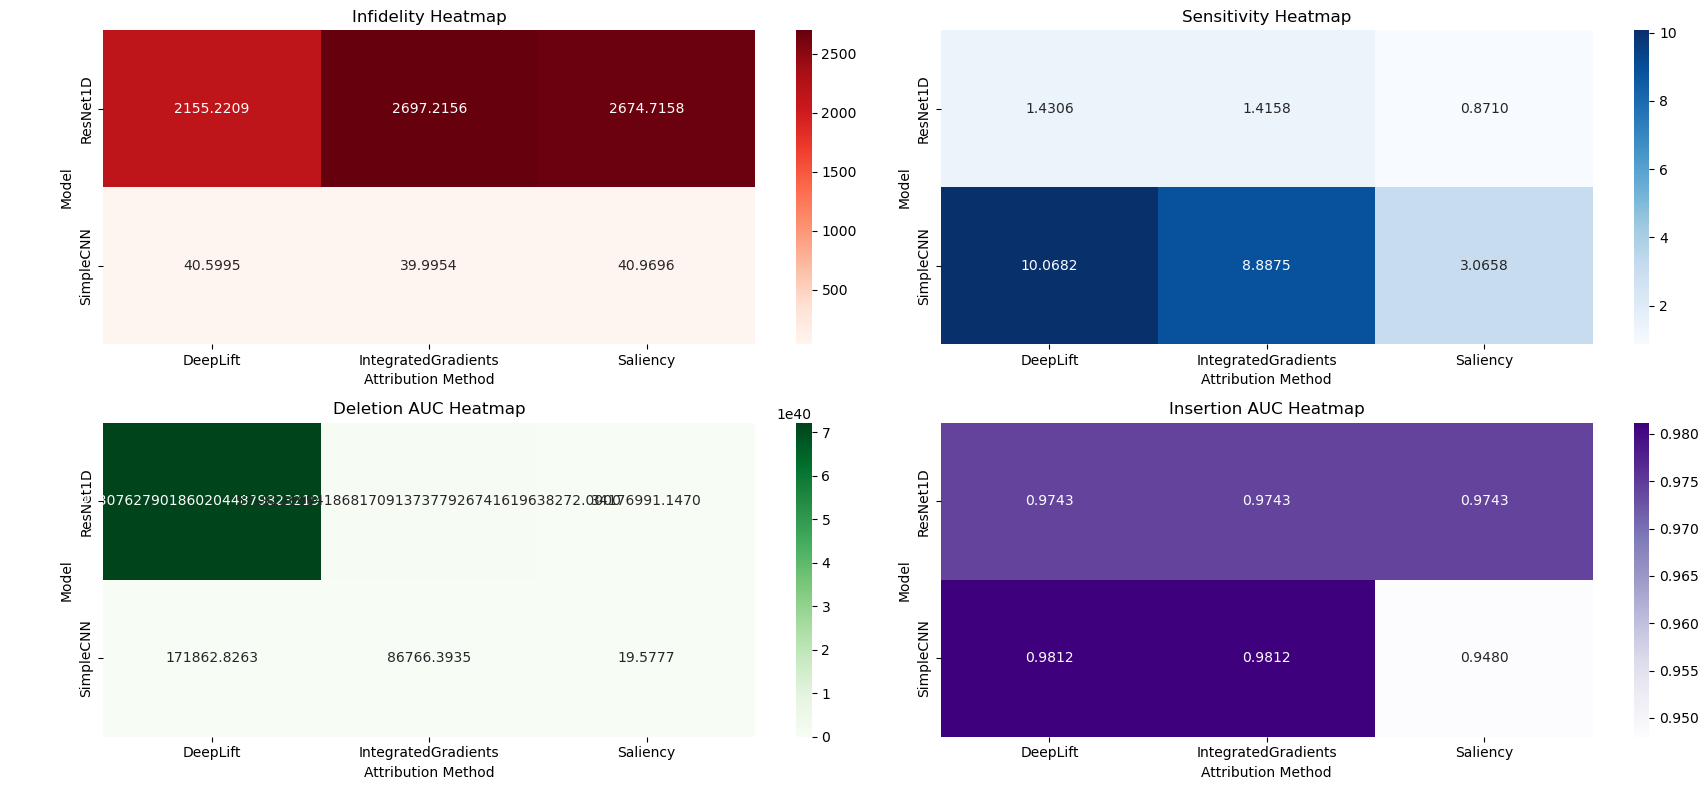

In [143]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from captum.attr import IntegratedGradients, Saliency, DeepLift
from captum.metrics import infidelity, sensitivity_max
from sklearn.metrics import auc

def deletion_insertion_curve(model, input_tensor, attributions, target, mode="deletion", steps=50):
    input_tensor = input_tensor.clone().detach().cpu().squeeze().numpy()
    attributions = attributions.squeeze().cpu().detach().numpy()
    sorted_idx = np.argsort(attributions)[::-1]  # Most important first
    baseline = np.zeros_like(input_tensor)
    scores = []
    modified = input_tensor.copy()
    for i in range(1, steps+1):
        k = int((i / steps) * len(sorted_idx))
        if mode == "deletion":
            modified = input_tensor.copy()
            modified[sorted_idx[:k]] = 0
        elif mode == "insertion":
            modified = baseline.copy()
            modified[sorted_idx[:k]] = input_tensor[sorted_idx[:k]]
        input_mod = torch.tensor(modified, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        prob = torch.softmax(model(input_mod), dim=1)[0, target].item()
        scores.append(prob)
    return scores

def calculate_auc(scores, mode="deletion"):
    """
    Calculate Area Under the Curve for insertion/deletion curves.
    For deletion: lower AUC is better (faster drop in confidence)
    For insertion: higher AUC is better (faster increase in confidence)
    """
    x = np.linspace(0, 1, len(scores))
    curve_auc = auc(x, scores)
    
    # For deletion curves, we want to normalize so that lower values are better
    # (consistent with other metrics where lower values indicate better attributions)
    if mode == "deletion":
        # Initial probability (unchanged input)
        p0 = scores[0]
        # Normalize to [0,1] where 0 is best (immediate drop to 0 probability)
        # and 1 is worst (no change in probability)
        normalized_auc = curve_auc / p0
        return normalized_auc
    else:  # insertion
        # For insertion, higher AUC is better
        # Normalize to [0,1] where 0 is best (immediate rise to max probability)
        normalized_auc = 1 - curve_auc
        return normalized_auc

def compute_all_metrics(model, sample, label, steps=20):
    """
    For a given model and a sample, compute Infidelity, Sensitivity, and AUC metrics 
    for each attribution method.
    """
    methods = {
        "IntegratedGradients": IntegratedGradients(model),
        "Saliency": Saliency(model),
        "DeepLift": DeepLift(model)
    }
    
    # Convert the label to a tensor if it's not already
    if isinstance(label, int):
        label_tensor = label
    else:
        label_tensor = label
    
    results = {}
    for name, attr_obj in methods.items():
        # Compute attributions; use n_steps for IntegratedGradients
        if name == "IntegratedGradients":
            attr_map = attr_obj.attribute(sample, target=label_tensor, n_steps=50)
        else:
            attr_map = attr_obj.attribute(sample, target=label_tensor)
            
        # Define a perturbation function for Infidelity:
        def perturb_fn(inputs):
            noise = torch.randn_like(inputs) * 0.1
            return noise, inputs - noise
        
        # Compute Infidelity with correct argument order:
        infid_value = infidelity(
            model,         # forward function
            perturb_fn,    # perturbation function
            sample,        # input tensor
            attr_map,      # precomputed attributions
            target=label_tensor   # target label
        ).item()
        
        # Fix for sensitivity_max - create a properly scoped function
        def create_attr_func(attribution_object, target):
            def attr_func(inputs):
                return attribution_object.attribute(inputs, target=target)
            return attr_func
        
        # Use the properly scoped attribution function
        attr_func = create_attr_func(attr_obj, label_tensor)
        
        # Compute Sensitivity with the fixed attribution function
        sens_value = sensitivity_max(
            attr_func,  # Use the new attribution function
            sample,
            n_perturb_samples=10,  # Use a reasonable number of perturbation samples
            perturb_radius=0.1     # Set a reasonable perturbation radius
        ).item()
        
        # Compute Deletion and Insertion AUC
        deletion_scores = deletion_insertion_curve(model, sample, attr_map, label_tensor, mode="deletion", steps=steps)
        insertion_scores = deletion_insertion_curve(model, sample, attr_map, label_tensor, mode="insertion", steps=steps)
        
        # Calculate AUC values
        deletion_auc = calculate_auc(deletion_scores, mode="deletion")
        insertion_auc = calculate_auc(insertion_scores, mode="insertion")
        
        results[name] = {
            "Infidelity": infid_value,
            "Sensitivity": sens_value,
            "Deletion AUC": deletion_auc,
            "Insertion AUC": insertion_auc
        }
    
    return results

def plot_deletion_insertion(model, input_tensor, attribution, target, title_prefix=""):
    del_scores = deletion_insertion_curve(model, input_tensor, attribution, target, mode="deletion")
    ins_scores = deletion_insertion_curve(model, input_tensor, attribution, target, mode="insertion")
    x = np.linspace(0, 1, len(del_scores))
    plt.figure(figsize=(10, 5))
    plt.plot(x, del_scores, label="Deletion", color='red')
    plt.plot(x, ins_scores, label="Insertion", color='green')
    plt.title(f"{title_prefix} - Deletion vs Insertion Curve")
    plt.xlabel("Fraction of Perturbed Input")
    plt.ylabel("Prediction Probability")
    plt.legend()
    plt.grid(True)
    plt.show()

# Get one sample from the test loader for evaluation
sample_batch, label_batch = next(iter(test_loader))
sample = sample_batch[0:1].to(device)  # shape: (1, 1, time_length)
label = label_batch[0].item()

# Compute metrics for both models
results_cnn = compute_all_metrics(model_cnn, sample, label, steps=20)
results_resnet = compute_all_metrics(model_resnet, sample, label, steps=20)

# Combine results into a nested dictionary
all_results = {
    "SimpleCNN": results_cnn,
    "ResNet1D": results_resnet
}

# Convert nested dictionary into a DataFrame for heatmap plotting
df_data = []
for model_name, methods in all_results.items():
    for method_name, metrics in methods.items():
        df_data.append([
            model_name, 
            method_name, 
            metrics["Infidelity"], 
            metrics["Sensitivity"],
            metrics["Deletion AUC"],
            metrics["Insertion AUC"]
        ])

df = pd.DataFrame(df_data, columns=["Model", "Method", "Infidelity", "Sensitivity", "Deletion AUC", "Insertion AUC"])
df.set_index(["Model", "Method"], inplace=True)

# Plot heatmaps for all metrics side by side
plt.figure(figsize=(18, 8))

# Infidelity Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(df["Infidelity"].unstack(), annot=True, cmap="Reds", fmt=".4f")
plt.title("Infidelity Heatmap")
plt.ylabel("Model")
plt.xlabel("Attribution Method")

# Sensitivity Heatmap
plt.subplot(2, 2, 2)
sns.heatmap(df["Sensitivity"].unstack(), annot=True, cmap="Blues", fmt=".4f")
plt.title("Sensitivity Heatmap")
plt.ylabel("Model")
plt.xlabel("Attribution Method")

# Deletion AUC Heatmap
plt.subplot(2, 2, 3)
sns.heatmap(df["Deletion AUC"].unstack(), annot=True, cmap="Greens", fmt=".4f")
plt.title("Deletion AUC Heatmap")
plt.ylabel("Model")
plt.xlabel("Attribution Method")

# Insertion AUC Heatmap
plt.subplot(2, 2, 4)
sns.heatmap(df["Insertion AUC"].unstack(), annot=True, cmap="Purples", fmt=".4f")
plt.title("Insertion AUC Heatmap")
plt.ylabel("Model")
plt.xlabel("Attribution Method")

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/opt/anaconda3/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/opt/anaconda3/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


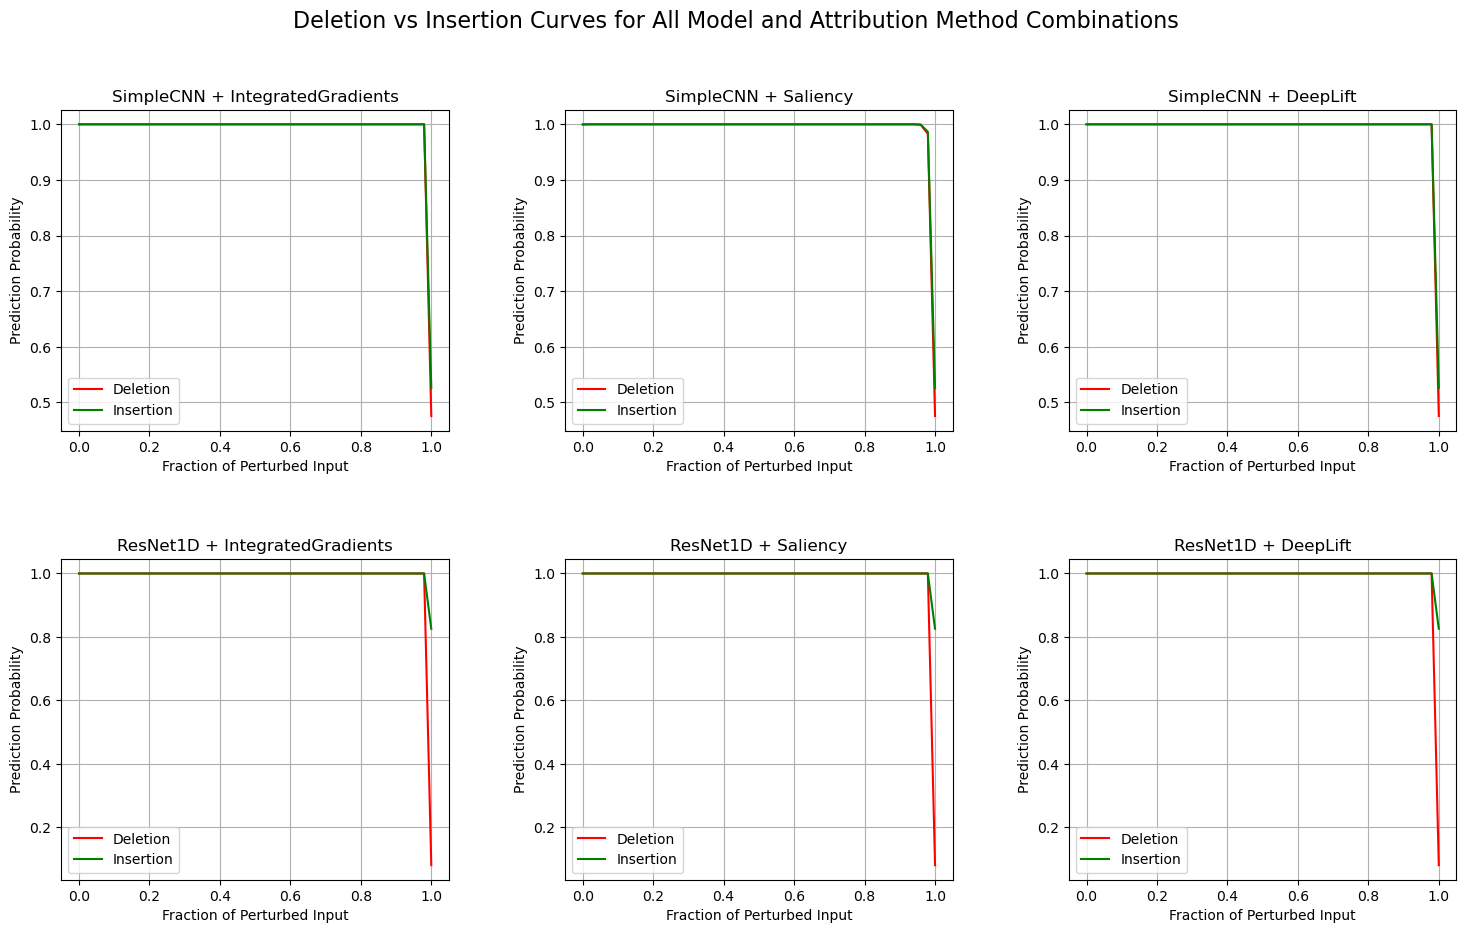

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from captum.attr import IntegratedGradients, Saliency, DeepLift

# Assume deletion_insertion_curve is defined as follows:
def deletion_insertion_curve(model, input_tensor, attributions, target, mode="deletion", steps=50):
    # Convert tensor to numpy array (squeezing extra dims)
    input_np = input_tensor.clone().detach().cpu().squeeze().numpy()
    attr_np = attributions.squeeze().cpu().detach().numpy()
    sorted_idx = np.argsort(attr_np)[::-1]  # Most important indices first
    baseline = np.zeros_like(input_np)
    scores = []
    for i in range(1, steps + 1):
        k = int((i / steps) * len(sorted_idx))
        if mode == "deletion":
            modified = input_np.copy()
            modified[sorted_idx[:k]] = 0
        elif mode == "insertion":
            modified = baseline.copy()
            modified[sorted_idx[:k]] = input_np[sorted_idx[:k]]
        # Convert modified input back to tensor with proper dimensions
        input_mod = torch.tensor(modified, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(input_tensor.device)
        prob = torch.softmax(model(input_mod), dim=1)[0, target].item()
        scores.append(prob)
    return scores

# A helper function to plot curves on a given axis.
def plot_deletion_insertion_ax(ax, model, input_tensor, attributions, target, title_prefix=""):
    del_scores = deletion_insertion_curve(model, input_tensor, attributions, target, mode="deletion")
    ins_scores = deletion_insertion_curve(model, input_tensor, attributions, target, mode="insertion")
    x = np.linspace(0, 1, len(del_scores))
    ax.plot(x, del_scores, label="Deletion", color="red")
    ax.plot(x, ins_scores, label="Insertion", color="green")
    ax.set_title(title_prefix)
    ax.set_xlabel("Fraction of Perturbed Input")
    ax.set_ylabel("Prediction Probability")
    ax.legend()
    ax.grid(True)

# Define your models in a dictionary
models_dict = {
    "SimpleCNN": model_cnn,
    "ResNet1D": model_resnet,
}

# Define attribution methods with their corresponding classes.
attr_methods = {
    "IntegratedGradients": IntegratedGradients,
    "Saliency": Saliency,
    "DeepLift": DeepLift,
}

# Get one sample from the test loader for visualization.
sample_batch, label_batch = next(iter(test_loader))
sample = sample_batch[0:1].to(device)  # shape: (1, 1, time_length)
label = label_batch[0].item()

# Create a 2x3 grid of subplots (2 models × 3 attribution methods)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Loop over models and attribution methods
for row_idx, (model_name, model) in enumerate(models_dict.items()):
    model.eval()  # set the model to evaluation mode
    for col_idx, (attr_name, attr_class) in enumerate(attr_methods.items()):
        # Instantiate the attribution object for the current model.
        attr_obj = attr_class(model)
        # Compute attributions. For IntegratedGradients, use n_steps; for others, default.
        if attr_name == "IntegratedGradients":
            attr_map = attr_obj.attribute(sample, target=label, n_steps=50)
        else:
            attr_map = attr_obj.attribute(sample, target=label)
        # Create title for subplot
        title_prefix = f"{model_name} + {attr_name}"
        # Plot the deletion/insertion curve into the corresponding axis.
        ax = axes[row_idx, col_idx]
        plot_deletion_insertion_ax(ax, model, sample, attr_map, label, title_prefix=title_prefix)

plt.suptitle("Deletion vs Insertion Curves for All Model and Attribution Method Combinations", fontsize=16)
plt.show()